<a href="https://colab.research.google.com/github/emm-gl/Referenz/blob/master/cont_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task Description

The overall target of the task is:
1. Extraction of timeseries data for actual temperature (TEMPERATUR INNEN_IST) and pressure (DRUCK INNEN_IST) values per cycle, based on the overall timeseries data within the give timeframe (2024-04-08 00:00:00 until 2024-04-10 23:59:59).
2. Plot a set of temperature / pressure curves (line plot per cycle).
3. Describe your data transformation steps in a small document (can be PowerPoint Presentation or Markdown File).
4. BONUS (optional): Detect cycles that are not okay based on the average shape of the actual temperature (TEMPERATUR INNEN_IST) and pressure (DRUCK INNEN_IST) values per cycle.

In [239]:
import pandas as pd
import os
import pyarrow.parquet as pq
from datetime import datetime
import matplotlib.pyplot as plt

In [240]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading data:


####Get the config file:

In [241]:
# Specify the path of JSON file in Google Drive
json_file_path = "/content/drive/My Drive/continental_challenge/ct-oesl-hiring-challenge-main/data/config/datapoints.json"

# Load the JSON file into a DataFrame
df_config = pd.read_json(json_file_path)

# Display the DataFrame
df_config

,uuid,label,config
0,00f9c223-6fd4-45ec-8ee2-62b9458c98fc,BETRIEBSINTERNE AUFTRAGSNUMMER,"{'rate': 'diff', 'source': {'name': 'datablock..."
1,9d7f979a-c50e-494c-9ee0-082eabe3143f,SAP BEZEICHNUNG,"{'rate': 'diff', 'source': {'name': 'datablock..."
2,8a1c7509-3c14-4f8f-b81c-0d44190ea305,ARTIKELNUMMER,"{'rate': 'diff', 'source': {'name': 'datablock..."
3,6a295488-d312-4c35-9c35-7347488f9846,AUFTRAGSMENGE_SOLL,"{'rate': 'diff', 'source': {'name': 'datablock..."
4,5cbb4233-dcbb-4e96-9111-0f0c36633303,AUFTRAGSMENGE_IST,"{'rate': 'diff', 'source': {'name': 'datablock..."
...,...,...,...
315,13e090fc-7683-4c8b-863f-0816dce05f55,DATEN.MIN_SOLLTEMP,"{'rate': 'diff', 'source': {'name': 'datablock..."
316,c053ad11-d895-4d7a-b02a-aa95f80b6618,DATEN.ISTDRUCK,"{'rate': 'diff', 'source': {'name': 'datablock..."
317,df83a9c8-aac7-4331-b6b5-a36d8d5c8c7d,ANALOGE_ISTWERTE.IST_TEMPERATUR.ISTWERT_INT,"{'rate': 'diff', 'source': {'name': 'datablock..."
318,2af6484d-a002-4404-ba05-30b960e8a9ba,ANALOGE_ISTWERTE.PEW_518.ISTWERT_INT,"{'rate': 'diff', 'source': {'name': 'datablock..."



According the config File:

89. TEMPERATUR INNEN_IST    
    UUID: 5cde150d-c044-4e55-8c48-73321e0c0f27     
    Data type: INT16

90. DRUCK INNEN_IST      
    UUID: 67da707a-735b-497d-9870-40349919814c     
    Data type: INT16

---

####Get the temperature dataframe:

In [242]:
# Function to search for parquet files with a certain file name (UUID) in a directory and its subdirectories,
# then create a dataframe with all the found parquet files

def get_data(file_name, root_dir):
    parquet_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.parquet') and file_name in file:
                parquet_files.append(os.path.join(root, file))

    # Create an empty DataFrame to store the combined data from all Parquet files
    df = pd.DataFrame()

    # Read each Parquet file and extract its content into the combined DataFrame
    for file_path in parquet_files:
        parquet_files = pq.read_table(file_path).to_pandas()
        df = pd.concat([df, parquet_files], ignore_index=True)

    return df

In [243]:
# Get the temperature data:
uuid_temp = "5cde150d-c044-4e55-8c48-73321e0c0f27"
root_dir = "/content/drive/My Drive/continental_challenge/ct-oesl-hiring-challenge-main/data/machine_data/"

df_temp = get_data(uuid_temp, root_dir)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412769 entries, 0 to 412768
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   uuid             412769 non-null  object 
 1   sequence_number  412769 non-null  int32  
 2   systime          412769 non-null  int64  
 3   plctime          412769 non-null  int64  
 4   is_delta         412769 non-null  bool   
 5   value_integer    412769 non-null  int64  
 6   value_string     0 non-null       object 
 7   value_double     0 non-null       float64
 8   value_bool       0 non-null       object 
 9   value_bytes      0 non-null       object 
dtypes: bool(1), float64(1), int32(1), int64(3), object(4)
memory usage: 27.2+ MB


Neither NaNs nor nulls nor mixed data types in labels: "systime" and "value_integer"

In [244]:
#Function to transform the systime column to date time format,
#then filter the data of the desired range:

def transform_filter(df, start_date, end_date):
    #Convert the timestamp "systime" to datetime format in a new column:
    df["system_time"] = df['systime'].apply(lambda x: x / 1e9)
    df["system_time"] = pd.to_datetime(df['system_time'], unit='s')

    #add ingestion_date
    df["ingestion_date"] = datetime.now()

    # Define start and end dates:
    start = pd.to_datetime(start_date)   #YY-MM-DD HH:MM:SS
    end = pd.to_datetime(end_date)       #YY-MM-DD HH:MM:SS

    # Filter rows where 'date' is within the range (inclusive)
    df_filtered = df[(df['system_time'] >= start) & (df['system_time'] <= end)]

    return df_filtered

In [245]:
df_temp = transform_filter(df_temp, '2024-04-08 00:00:00','2024-04-10 23:59:59')
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412769 entries, 0 to 412768
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   uuid             412769 non-null  object        
 1   sequence_number  412769 non-null  int32         
 2   systime          412769 non-null  int64         
 3   plctime          412769 non-null  int64         
 4   is_delta         412769 non-null  bool          
 5   value_integer    412769 non-null  int64         
 6   value_string     0 non-null       object        
 7   value_double     0 non-null       float64       
 8   value_bool       0 non-null       object        
 9   value_bytes      0 non-null       object        
 10  system_time      412769 non-null  datetime64[ns]
 11  ingestion_date   412769 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(1), int32(1), int64(3), object(4)
memory usage: 33.5+ MB


In [261]:
#Select only the required columns
df_temperature = df_temp[["uuid",
                          "sequence_number",
                          "systime",
                          "plctime",
                          "is_delta",
                          "value_integer",
                          "system_time",
                          "ingestion_date"
                          ]]

In [262]:
df_temperature.head(3)

,uuid,sequence_number,systime,plctime,is_delta,value_integer,system_time,ingestion_date
0,5cde150d-c044-4e55-8c48-73321e0c0f27,0,1712620800318265586,1712627999115000000,True,145,2024-04-09 00:00:00.318265600,2024-04-24 22:19:22.399055
1,5cde150d-c044-4e55-8c48-73321e0c0f27,0,1712620800440277299,1712627999238000000,True,144,2024-04-09 00:00:00.440277248,2024-04-24 22:19:22.399055
2,5cde150d-c044-4e55-8c48-73321e0c0f27,0,1712620800688215328,1712627999485000000,True,145,2024-04-09 00:00:00.688215296,2024-04-24 22:19:22.399055


In [263]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412769 entries, 0 to 412768
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   uuid             412769 non-null  object        
 1   sequence_number  412769 non-null  int32         
 2   systime          412769 non-null  int64         
 3   plctime          412769 non-null  int64         
 4   is_delta         412769 non-null  bool          
 5   value_integer    412769 non-null  int64         
 6   system_time      412769 non-null  datetime64[ns]
 7   ingestion_date   412769 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 20.9+ MB


In [264]:
df_temperature["value_integer"].describe()

count    412769.000000
mean        140.766274
std          12.430762
min          88.000000
25%         134.000000
50%         144.000000
75%         152.000000
max         156.000000
Name: value_integer, dtype: float64

####Get the pressure (drück) dataframe:

In [250]:
# Get the pressure data:
uuid_druck = "67da707a-735b-497d-9870-40349919814c"
root_dir = "/content/drive/My Drive/continental_challenge/ct-oesl-hiring-challenge-main/data/machine_data/"

df_druck = get_data(uuid_druck, root_dir)
df_druck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206356 entries, 0 to 206355
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   uuid             206356 non-null  object 
 1   sequence_number  206356 non-null  int32  
 2   systime          206356 non-null  int64  
 3   plctime          206356 non-null  int64  
 4   is_delta         206356 non-null  bool   
 5   value_integer    206356 non-null  int64  
 6   value_string     0 non-null       object 
 7   value_double     0 non-null       float64
 8   value_bool       0 non-null       object 
 9   value_bytes      0 non-null       object 
dtypes: bool(1), float64(1), int32(1), int64(3), object(4)
memory usage: 13.6+ MB


Neither NaNs nor nulls nor mixed data types in labels: "systime" and "value_integer"

In [251]:
#Transform the systime and filter the data of specified range:

df_pressure = transform_filter(df_druck, '2024-04-08 00:00:00','2024-04-10 23:59:59')
df_pressure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206356 entries, 0 to 206355
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   uuid             206356 non-null  object        
 1   sequence_number  206356 non-null  int32         
 2   systime          206356 non-null  int64         
 3   plctime          206356 non-null  int64         
 4   is_delta         206356 non-null  bool          
 5   value_integer    206356 non-null  int64         
 6   value_string     0 non-null       object        
 7   value_double     0 non-null       float64       
 8   value_bool       0 non-null       object        
 9   value_bytes      0 non-null       object        
 10  system_time      206356 non-null  datetime64[ns]
 11  ingestion_date   206356 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(1), int32(1), int64(3), object(4)
memory usage: 16.7+ MB


In [269]:
#Select only the required columns
df_pressure = df_pressure[["uuid",
                          "sequence_number",
                          "systime",
                          "plctime",
                          "is_delta",
                          "value_integer",
                          "system_time",
                          "ingestion_date"
                          ]]

In [270]:
df_pressure.head(3)

,uuid,sequence_number,systime,plctime,is_delta,value_integer,system_time,ingestion_date
0,67da707a-735b-497d-9870-40349919814c,0,1712620800580196435,1712627999377000000,False,3,2024-04-09 00:00:00.580196352,2024-04-24 22:19:48.298669
1,67da707a-735b-497d-9870-40349919814c,0,1712620801584247781,1712628000381000000,False,3,2024-04-09 00:00:01.584247808,2024-04-24 22:19:48.298669
2,67da707a-735b-497d-9870-40349919814c,0,1712620802584316227,1712628001379000000,False,3,2024-04-09 00:00:02.584316160,2024-04-24 22:19:48.298669


In [271]:
df_pressure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206356 entries, 0 to 206355
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   uuid             206356 non-null  object        
 1   sequence_number  206356 non-null  int32         
 2   systime          206356 non-null  int64         
 3   plctime          206356 non-null  int64         
 4   is_delta         206356 non-null  bool          
 5   value_integer    206356 non-null  int64         
 6   system_time      206356 non-null  datetime64[ns]
 7   ingestion_date   206356 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 10.4+ MB


In [272]:
df_pressure["value_integer"].describe()

count    206356.000000
mean          1.846343
std           1.851498
min           0.000000
25%           0.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: value_integer, dtype: float64

## Plotting:

In [267]:
def plot(df, y_column_name, title, x_label, y_label):
    """
    Plots a specified column of the resampled DataFrame.

    Parameters:
        df_resampled (DataFrame): Resampled DataFrame containing datetime index.
        column_name (str): Name of the column to plot.

    Returns:
        None
    """
    #Isolate numerical data
    df_plot = df[["value_integer", "system_time", "ingestion_date"]]
    df_plot.set_index('system_time', inplace=True)

    #Resample each second to plot propperly
    df_resampled = df_plot.resample('T').mean()

    plt.figure(figsize=(22, 6))  # Adjust figure size as needed
    plt.plot(df_resampled[y_column_name])
    plt.xlabel(x_label)    # Add label for x-axis
    plt.ylabel(y_label)    # Add label for y-axis
    plt.title(title)  # Add title to the plot
    plt.grid(True)                # Add gridlines
    plt.show()

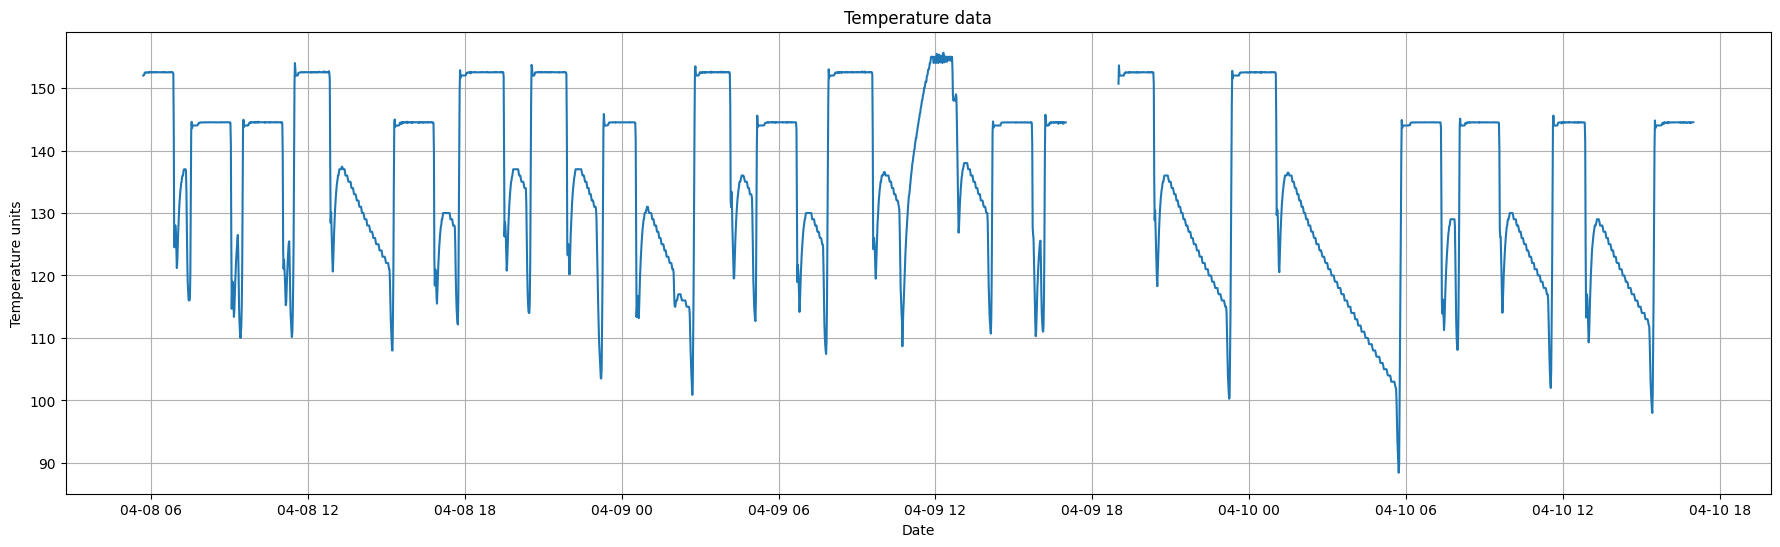

In [268]:
plot(df_temperature, "value_integer", "Temperature data", "Date", "Temperature units")

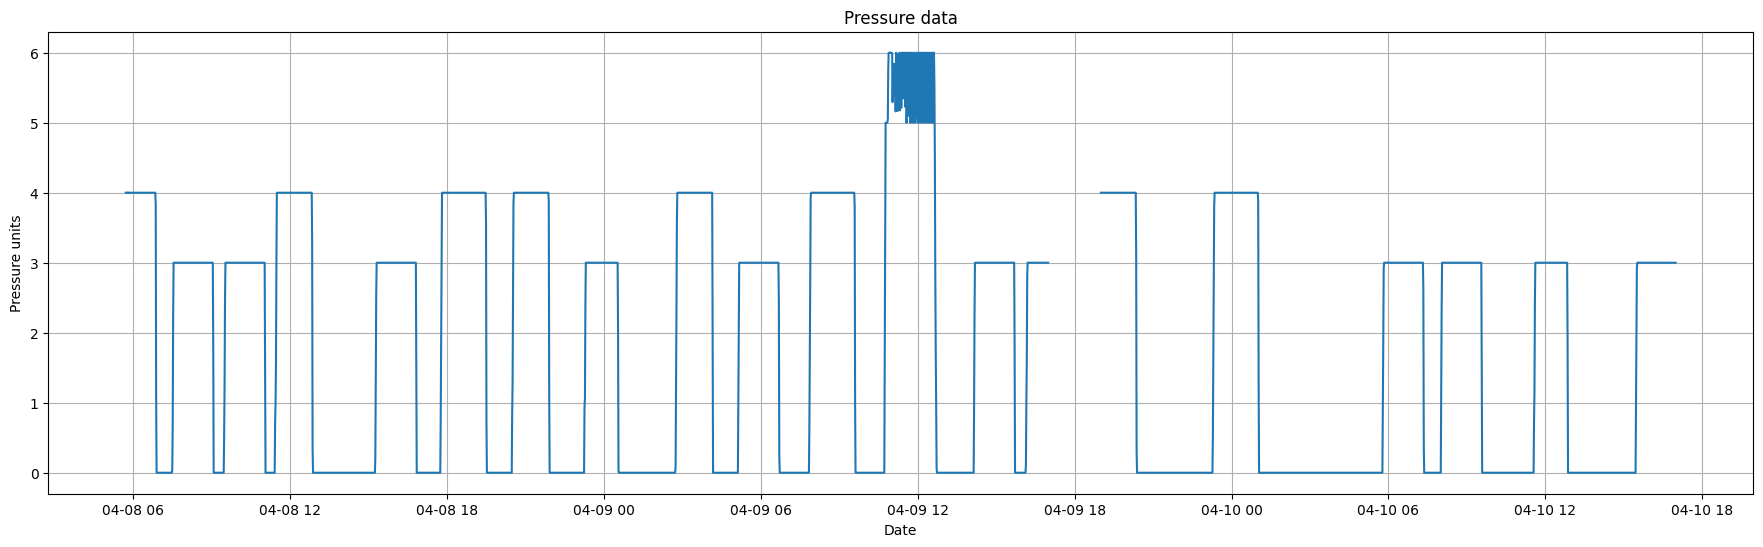

In [273]:
plot(df_pressure, "value_integer", "Pressure data", "Date", "Pressure units")